# Lesson 7 - Parkinson PCR

## Author - Kenji Oman

### Description:

Perform Principal Component Regression on a <a href="https://archive.ics.uci.edu/ml/datasets/parkinsons+telemonitoring">dataset that tracked patients with Parkinson's Disease</a>.

Citation: A Tsanas, MA Little, PE McSharry, LO Ramig (2009)
'Accurate telemonitoring of Parkinson's disease progression by non-invasive speech tests',
IEEE Transactions on Biomedical Engineering.

About the data:
This dataset is composed of a range of biomedical voice measurements from 42 
people with early-stage Parkinson's disease recruited to a six-month trial of 
a telemonitoring device for remote symptom progression monitoring. The 
recordings were automatically captured in the patient's homes.

#### Instructions:

 1. Load the dataset.
 2. Create the X-matrix (one-hot encoding categorical factors).
 3. Scale the X-matrix.
 4. Create the principal components and do a simple plot of the explained variance.
 5. PCR - Linear regression with the principal components.

Report on:

 1. Number of components before and after (choose a smaller number of principal components and explain how you chose them).
 2. Interpret the adjusted R-squared.

In [1]:
filename = "https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/telemonitoring/parkinsons_updrs.data"

In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import seaborn as sns

In [3]:
parkinsons_df = pd.read_csv(filename)
parkinsons_df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


In [4]:
parkinsons_df.columns

Index(['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS', 'total_UPDRS',
       'Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5', 'Jitter:DDP',
       'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5',
       'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR', 'RPDE', 'DFA', 'PPE'],
      dtype='object')

In [5]:
# Define the target and features:
target_label = 'total_UPDRS'
non_features = ['subject#', 'age', 'sex', 'test_time', 'motor_UPDRS']
feature_labels = [x for x in parkinsons_df.columns if x not in [target_label] + non_features]

# Filter out non-features and non-targets
parkinsons_df = parkinsons_df.drop(non_features, axis=1, errors='ignore')

# One-hot encode inputs
parkinsons_expanded = pd.get_dummies(parkinsons_df, drop_first=True)
print('DataFrame one-hot-expanded shape: {}'.format(parkinsons_expanded.shape))

# Get target and original x-matrix
y = parkinsons_df[target_label]
X = parkinsons_df.loc[:, feature_labels].values

DataFrame one-hot-expanded shape: (5875, 17)


In [6]:
# Scale function
def scale(col):
    mean_col = np.mean(col)
    sd_col = np.std(col)
    std = (col - mean_col) / sd_col
    return std

In [7]:
# Scale all columns first

# Create x-scaled (look into the function np.apply_along_axis to apply 'scale' function
#    to each column)
x_scaled = np.apply_along_axis(scale, 1, X)

# Create a scaled y-target
y_scaled = np.apply_along_axis(scale, 0, y)

In [8]:
# PCR!!
pca = PCA()
pca_result = pca.fit_transform(x_scaled)

column_names = ['pc' + str(ix+1) for ix in range(pca.components_.shape[0])]
pca_df = pd.DataFrame(data = pca_result, columns=column_names)
pca_df[target_label] = y_scaled

## Variance Explained

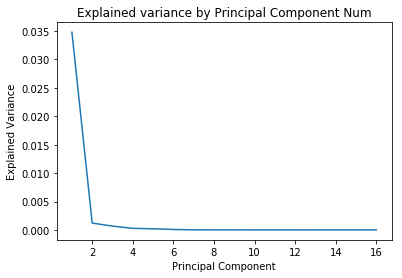

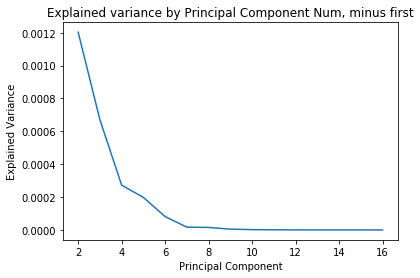

In [9]:
# Plot the explained variance for all 111 principal components
# Note: If the first value is too large, it may dwarf how the rest look.
#   You may consider plotting starting with the 2nd value (python index at 1)
plt.plot(range(1, len(pca.explained_variance_)+1), pca.explained_variance_)
plt.title('Explained variance by Principal Component Num')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()
plt.plot(range(2, len(pca.explained_variance_)+1), pca.explained_variance_[1:])
plt.title('Explained variance by Principal Component Num, minus first')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.show()

In [10]:
# Let's look at how much of the explainable variance is explained by
# the first N PCs
print("Total variance captured:", pca.explained_variance_.sum())
print("Now, contributions from each component:")
for i in range(pca.explained_variance_.shape[0]):
    print('{0}: {1}'.format(i+1, pca.explained_variance_[:(i+1)].sum()/pca.explained_variance_.sum()))

Total variance captured: 0.037247410093115337
Now, contributions from each component:
1: 0.9338492570809234
2: 0.9661475583469776
3: 0.984138644562929
4: 0.9914531630343191
5: 0.9967602479889521
6: 0.9989397877899777
7: 0.9993916221249853
8: 0.9997981218933313
9: 0.9999245072448448
10: 0.9999729861916847
11: 0.9999938205356322
12: 0.9999984261242743
13: 0.9999999995834521
14: 0.9999999999911222
15: 1.0000000000000007
16: 1.0


From the above, it looks like the **first 4 principal components explain over 99% of the explainable variance across our features, so let's use 4 PCs** for our regression.  Now, let's take a look at which columns make up these first 4 PCs.

## Feature contributions to principal components

In [11]:
# Let's look at what columns make up these first 4 components
# First, grab the column names
temp = np.reshape(np.array(feature_labels*4), (4,16))
temp[0, :]

array(['Jitter(%)', 'Jitter(Abs)', 'Jitter:RAP', 'Jitter:PPQ5',
       'Jitter:DDP', 'Shimmer', 'Shimmer(dB)', 'Shimmer:APQ3',
       'Shimmer:APQ5', 'Shimmer:APQ11', 'Shimmer:DDA', 'NHR', 'HNR',
       'RPDE', 'DFA', 'PPE'], dtype='<U13')

In [12]:
# Now, show the amount of contribution made to the first 4 PCs, by
# the different columns, per PC
np.sort(np.abs(pca.components_[:4,:]))[:, ::-1]/ np.abs(pca.components_[:4, :]).sum(axis=1).reshape(-1,1)

array([[0.27581064, 0.09182259, 0.08146416, 0.06060034, 0.05580498,
        0.05388448, 0.05291339, 0.05133978, 0.05119951, 0.04612157,
        0.04256456, 0.03861231, 0.03531149, 0.03386958, 0.02227996,
        0.00640068],
       [0.18378242, 0.14132817, 0.12831453, 0.10808082, 0.07982223,
        0.03924077, 0.03569541, 0.03550051, 0.03309369, 0.03306896,
        0.03239068, 0.03165709, 0.03130362, 0.03056636, 0.03003267,
        0.02612208],
       [0.18793764, 0.17690865, 0.15661754, 0.13517321, 0.11106062,
        0.08072751, 0.03910596, 0.02660421, 0.02258378, 0.02025675,
        0.0180517 , 0.0117686 , 0.00745725, 0.00423078, 0.00109404,
        0.00042174],
       [0.33372983, 0.29020634, 0.18373776, 0.03975645, 0.03660976,
        0.02402113, 0.01707494, 0.01691213, 0.01356824, 0.01156551,
        0.01050499, 0.00845839, 0.00521404, 0.00444108, 0.0026085 ,
        0.00159093]])

In [13]:
# Now, Show what these column names are that contributed these amounts
np.take(temp, np.argsort(np.abs(pca.components_[:4,:]))[:, ::-1])

array([['Shimmer(dB)', 'HNR', 'RPDE', 'Jitter(Abs)', 'Jitter:RAP',
        'Jitter:PPQ5', 'DFA', 'Jitter(%)', 'NHR', 'Jitter:DDP',
        'Shimmer:APQ3', 'PPE', 'Shimmer:APQ5', 'Shimmer:APQ11',
        'Shimmer', 'Shimmer:DDA'],
       ['HNR', 'NHR', 'RPDE', 'DFA', 'PPE', 'Jitter:DDP', 'Jitter(%)',
        'Jitter:PPQ5', 'Jitter:RAP', 'Shimmer', 'Shimmer:APQ5',
        'Shimmer:DDA', 'Shimmer(dB)', 'Shimmer:APQ3', 'Jitter(Abs)',
        'Shimmer:APQ11'],
       ['HNR', 'Shimmer(dB)', 'RPDE', 'DFA', 'NHR', 'PPE', 'Shimmer:DDA',
        'Shimmer', 'Shimmer:APQ11', 'Shimmer:APQ5', 'Shimmer:APQ3',
        'Jitter:DDP', 'Jitter(Abs)', 'Jitter(%)', 'Jitter:RAP',
        'Jitter:PPQ5'],
       ['RPDE', 'PPE', 'DFA', 'HNR', 'NHR', 'Shimmer:DDA',
        'Shimmer:APQ3', 'Shimmer:APQ5', 'Jitter(Abs)', 'Jitter:DDP',
        'Shimmer', 'Shimmer(dB)', 'Jitter:RAP', 'Jitter(%)',
        'Jitter:PPQ5', 'Shimmer:APQ11']], dtype='<U13')

From the above, we see that the first 4 PCs have fairly signifcant contributions from a large number of columns (granted, this isn't exactly right since each column can contribute positively and negatively towards the final PC value, and we really need all the columns to get the PC to explain the full variance that it does, but we do get an idea of the relative weights each column plays in generating each PC).  From this we see:

* Shimmer(dB) alone carries ~27.6% of the weight going into PC1, with the remaining columns contributing ~2-9% of the weights.
* PC2 has contributions spread out among more columns, with HNR, NHR, RPDE, and DFA all contributing over 10% of the weights.
* PC3 also has a larger number of columns contrubing over 10% (HNR, Shimmer(dB), RPDE, DFA, NHR)
* PC4 has most of it's weights contributed by 3 columns: RPDE, PPE, and DFA.

So, **Shimmer(dB), HNR, NHR, RPDE, DFA, and PPE seem to be roughly the 6 most important columns from the original 16**.

Now, on to see how well our PCA regression works.

## PCA Regression with 4 components

                            OLS Regression Results                            
Dep. Variable:            total_UPDRS   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     22.15
Date:                Wed, 23 May 2018   Prob (F-statistic):           3.60e-18
Time:                        08:37:07   Log-Likelihood:                -8292.3
No. Observations:                5875   AIC:                         1.659e+04
Df Residuals:                    5870   BIC:                         1.663e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.679e-16      0.013  -5.16e-14      1.0

/home/koman/miniconda3/envs/dsc/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


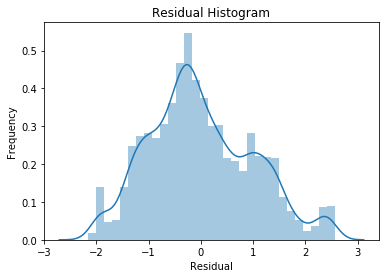

In [14]:
# Perform linear regression with the first N columns
n = 4
formula_start = target_label + ' ~ '
formula_terms = ['pc' + str(x+1) for x in range(n)]
formula_end = ' + '.join(formula_terms)
formula_final = formula_start + formula_end

pcr_model = sm.ols(formula = formula_final, data=pca_df)

results = pcr_model.fit()

# Get most of the linear regression statistics we are interested in:
print(results.summary())

# Plot a histogram of the residuals
sns.distplot(results.resid, hist=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Histogram')
plt.show()

## Summary
From the above, we see that PC3 is not significantly associated with the target variable of 'total_UPDRS', but the remaining 3 components are significantly associated.  However, only 1.4% of the variance in total_UPDRS is explained by these 4 principal components (the adjusted $R^2$).  Although we captured most of the information that can be captured by combining the original columns (with 4 PCs, we captured over 99% of the capturable variance), as PC3 wasn't even associted with our target variable, there may be some lower level components that are more significantly associated with total_UPDRS.  We would have to perform stepwise regression to see if we can discover some features that are more strongly associated (and, if we were to investigate further, perhaps we would see one of the original columns is much more strongly associated with the total_UPDRS, and PCA just mixes/ weakens this signal with the variability present in other columns).

So, in conclusion, although PCA is a quick/ easy way of decreasing the number of features, it isn't a cure-all to the problem of feature selection.